# CEO-REQUEST CHALLENGE

> Should Olist remove underperforming sellers from its marketplace?

## Problem statement

To analyse the impact of removing the worse sellers from Olist's marketplace, we can start with a what-if analysis: What would have happened if Olist had never accepted these sellers in the first place? For that:

Step ① Compute, for each `seller_id`, and cumulated since the beginning:
- The `revenues` it brings
- The `costs` associated with all its bad reviews
- The resulting `profits` (revenues - costs)
- The number of `orders` (it will impact overall IT costs)


Step ② We can then sort sellers by increasing profits for Olist, and for each number of sellers to remove, compute the financial impact it would have made had they never been accepted on the platform. We may find an optimal number of sellers to remove that maximizes Olist's profit margin

In [1]:
# Write down a detailed strategy (step by step) to create the DataFrame you need for step 1
# Think about how to re-use or update the logic you have already coded in your `olist` package

<details>
    <summary>Hints</summary>


Starting from your current `seller().get_training_data()` DataFrame:
- Can you easily transform it to compute Olist's positive `revenue_per_seller`? 
- Can you easily transform it to compute Olist's `cost_of_bad_reviews`?

❓Instead of starting again from scratch, investigate your source code in `seller.py` - how was the mean `review_score` per seller computed? Can you imagine a way to amend your code  to compute `cost_of_reviews` in the same process? 
</details>


In [2]:
%load_ext autoreload
%autoreload 2

In [33]:
#Import models
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from olist.data import Olist
from olist.order import Order
from olist.seller import Seller
from olist.seller_updated_solution import Seller as SellerUpdated
import datetime as dt
import math

In [34]:
# Import data
tmp_master_df = Olist().get_data()
sellers = SellerUpdated().get_training_data()

# Create a table linking order_id and seller_id
order_seller = tmp_master_df['order_items'][['order_id','seller_id']]


## Your turn!

In [35]:
##Slice the sellers dataframe
profit_per_seller_desc = sellers[['seller_id', 'n_orders','revenues','cost_of_reviews','profits']].sort_values('profits', ignore_index = True, ascending = False)
profit_per_seller_desc


,seller_id,n_orders,revenues,cost_of_reviews,profits
0,53243585a1d6dc2643021fd1853d8905,358,23237.605,5270,17967.605
1,7e93a43ef30c4f03f38b393420bc753a,336,19323.187,4800,14523.187
2,fa1c13f2614d7b5c4749cbc52fecda94,585,21004.203,6750,14254.203
3,edb1ef5e36e0c8cd84eb3c9b003e486d,166,8808.455,1520,7288.455
4,ccc4bbb5f32a6ab2b7066a4130f114e3,187,8920.462,2220,6700.462
...,...,...,...,...,...
2965,8b321bb669392f5163d04c59e235e066,943,2553.569,15620,-13066.431
2966,ea8482cd71df3c1969d7b9473ff13abc,1146,4677.752,20710,-16032.248
2967,cc419e0650a3c5ba77189a1882b7556a,1706,11948.842,30000,-18051.158
2968,4a3ca9315b744ce9f8e9374361493884,1806,21647.292,40890,-19242.708


In [36]:
#This shows the distributions of profits
profit_per_seller_desc['cum_sum_profit'] = profit_per_seller_desc['profits'].cumsum()
profit_per_seller_desc

,seller_id,n_orders,revenues,cost_of_reviews,profits,cum_sum_profit
0,53243585a1d6dc2643021fd1853d8905,358,23237.605,5270,17967.605,17967.605
1,7e93a43ef30c4f03f38b393420bc753a,336,19323.187,4800,14523.187,32490.792
2,fa1c13f2614d7b5c4749cbc52fecda94,585,21004.203,6750,14254.203,46744.995
3,edb1ef5e36e0c8cd84eb3c9b003e486d,166,8808.455,1520,7288.455,54033.450
4,ccc4bbb5f32a6ab2b7066a4130f114e3,187,8920.462,2220,6700.462,60733.912
...,...,...,...,...,...,...
2965,8b321bb669392f5163d04c59e235e066,943,2553.569,15620,-13066.431,1192790.855
2966,ea8482cd71df3c1969d7b9473ff13abc,1146,4677.752,20710,-16032.248,1176758.607
2967,cc419e0650a3c5ba77189a1882b7556a,1706,11948.842,30000,-18051.158,1158707.449
2968,4a3ca9315b744ce9f8e9374361493884,1806,21647.292,40890,-19242.708,1139464.741


<function matplotlib.pyplot.show(close=None, block=None)>

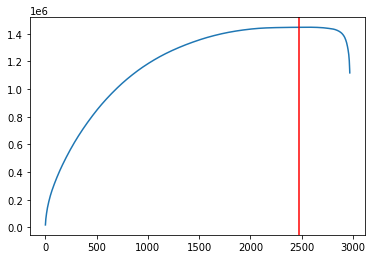

In [37]:
plt.plot(profit_per_seller_desc['cum_sum_profit'])
plt.axvline(2475, color = 'r') 
plt.show

In [38]:
current_profit = profit_per_seller_desc['profits'].sum()-500000
current_profit

616965.2240000002

In [39]:
#LEt's now start to take into account the IT costs


#Get the orders table
orders = tmp_master_df['orders'][['order_id']]

#Find number of orders
total_orders = orders.count()
total_orders
# Total it costs = a*sqrt(num_orders_processed)
# Therefore 
# a = total_it_costs/sqrt(total_orders)
# Current IT costs = 500000
a = 500000/(total_orders**.5)

a

order_id    1585.576728
dtype: float64

In [40]:
profit_per_seller_desc['cum_orders'] = profit_per_seller_desc['n_orders'].cumsum()

#define a function to work out IT costs
def it_costs(orders):
    a = 1585.576728
    return a*(orders**.5)
    
profit_per_seller_desc['IT_costs'] = profit_per_seller_desc['cum_orders'].apply(it_costs)
profit_per_seller_desc['net_profit'] = profit_per_seller_desc['cum_sum_profit']- profit_per_seller_desc['IT_costs']
profit_per_seller_desc

,seller_id,n_orders,revenues,cost_of_reviews,profits,cum_sum_profit,cum_orders,IT_costs,net_profit
0,53243585a1d6dc2643021fd1853d8905,358,23237.605,5270,17967.605,17967.605,358,30000.519572,-12032.914572
1,7e93a43ef30c4f03f38b393420bc753a,336,19323.187,4800,14523.187,32490.792,694,41770.242648,-9279.450648
2,fa1c13f2614d7b5c4749cbc52fecda94,585,21004.203,6750,14254.203,46744.995,1279,56705.154120,-9960.159120
3,edb1ef5e36e0c8cd84eb3c9b003e486d,166,8808.455,1520,7288.455,54033.450,1445,60272.774905,-6239.324905
4,ccc4bbb5f32a6ab2b7066a4130f114e3,187,8920.462,2220,6700.462,60733.912,1632,64054.159978,-3320.247978
...,...,...,...,...,...,...,...,...,...
2965,8b321bb669392f5163d04c59e235e066,943,2553.569,15620,-13066.431,1192790.855,93332,484398.231724,708392.623276
2966,ea8482cd71df3c1969d7b9473ff13abc,1146,4677.752,20710,-16032.248,1176758.607,94478,487363.060025,689395.546975
2967,cc419e0650a3c5ba77189a1882b7556a,1706,11948.842,30000,-18051.158,1158707.449,96184,491743.558830,666963.890170
2968,4a3ca9315b744ce9f8e9374361493884,1806,21647.292,40890,-19242.708,1139464.741,97990,496338.703288,643126.037712


**Olist would be more profitable if underperforming sellers had not joined Olist**

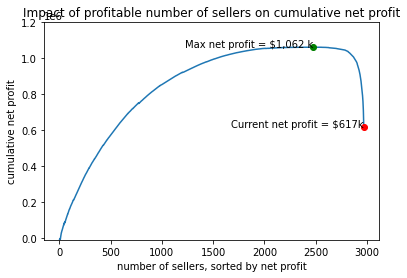

In [50]:
plt.plot(profit_per_seller_desc['net_profit'])
plt.text(2969,616965,'Current net profit = $617k',horizontalalignment = 'right')
plt.plot(2969,616965, 'ro')
plt.text(2475,1061666,'Max net profit = $1,062 k',horizontalalignment = 'right')
plt.plot(2475,1061666, 'go')


plt.title('Impact of profitable number of sellers on cumulative net profit')
plt.xlabel('number of sellers, sorted by net profit')
plt.ylabel('cumulative net profit')
plt.ylim(-10000,1200000)
plt.show()


If only the top 2475 sellers remained with Olist, the company's net profit to date would be \\$1,062 k, much higher than the current net profit of \$617 k.

It is therefore recommended that Olist look at ways of identifying and removing underperforming sellers.

**Method**

To get to this conclusion, the number of sellers were sorted by profit. The cumulative IT costs were then factored in determine the cumulative net profit. The table below shows the top 5 sellers.

In [57]:
profit_per_seller_desc[['seller_id','profits','cum_sum_profit','cum_orders','IT_costs','net_profit']].head(5)

,seller_id,profits,cum_sum_profit,cum_orders,IT_costs,net_profit
0,53243585a1d6dc2643021fd1853d8905,17967.605,17967.605,358,30000.519572,-12032.914572
1,7e93a43ef30c4f03f38b393420bc753a,14523.187,32490.792,694,41770.242648,-9279.450648
2,fa1c13f2614d7b5c4749cbc52fecda94,14254.203,46744.995,1279,56705.154120,-9960.159120
3,edb1ef5e36e0c8cd84eb3c9b003e486d,7288.455,54033.450,1445,60272.774905,-6239.324905
4,ccc4bbb5f32a6ab2b7066a4130f114e3,6700.462,60733.912,1632,64054.159978,-3320.247978


**Note: Underperformance still needs to be clearly defined**

This analysis shows that at a high level, it would be financially beneficial for Olist to remove underperforming sellers. The detailed outcome of this analysis should be treated with caution...

The graph below is a zoomed in version of the graph on the previous slide. The red line represents the 2475th top ranked seller.

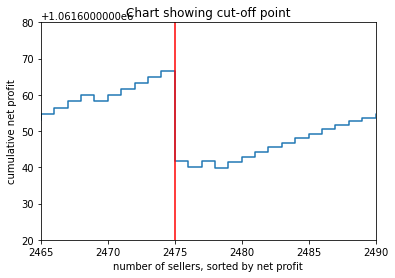

In [54]:
plt.step(profit_per_seller_desc.index.values, profit_per_seller_desc['net_profit'])
plt.axvline(2475, color = 'r') 
plt.title('Chart showing cut-off point')
plt.xlabel('number of sellers, sorted by net profit')
plt.ylabel('cumulative net profit')
plt.xlim(2465,2490)
plt.ylim(1061620,1061680)
plt.show()

If we would take the red line as a 'cut off point', we would unnecessarily remove profitable sellers from Olist. 

In [21]:
top_sellers_to_keep_mp_df = profit_per_seller_desc[profit_per_seller_desc['net_profit'] == max(profit_per_seller_desc['net_profit'])]

#Add percent change
top_sellers_to_keep_mp_df

,seller_id,n_orders,revenues,cost_of_reviews,profits,cum_sum_profit,cum_orders,IT_costs,net_profit
2475,417a1e6c7321084d2a0ae0d023cfad93,1,4.89,0,4.89,1446484.987,58903,384818.524589,1.061666e+06


In [22]:
profit_per_seller_desc.head(5)


,seller_id,n_orders,revenues,cost_of_reviews,profits,cum_sum_profit,cum_orders,IT_costs,net_profit
0,53243585a1d6dc2643021fd1853d8905,358,23237.605,5270,17967.605,17967.605,358,30000.519572,-12032.914572
1,7e93a43ef30c4f03f38b393420bc753a,336,19323.187,4800,14523.187,32490.792,694,41770.242648,-9279.450648
2,fa1c13f2614d7b5c4749cbc52fecda94,585,21004.203,6750,14254.203,46744.995,1279,56705.154120,-9960.159120
3,edb1ef5e36e0c8cd84eb3c9b003e486d,166,8808.455,1520,7288.455,54033.450,1445,60272.774905,-6239.324905
4,ccc4bbb5f32a6ab2b7066a4130f114e3,187,8920.462,2220,6700.462,60733.912,1632,64054.159978,-3320.247978


In [23]:
profit_per_seller_desc[2470:2490]

,seller_id,n_orders,revenues,cost_of_reviews,profits,cum_sum_profit,cum_orders,IT_costs,net_profit
2470,e0487761face83d64fcada2408959a36,2,4.925,0,4.925,1446460.499,58898,384802.191520,1.061658e+06
2471,d63f306de130e0391d38a792541723b8,1,4.900,0,4.900,1446465.399,58899,384805.458190,1.061660e+06
2472,2ef086a599b597572aca4433b7ed6b3d,1,4.900,0,4.900,1446470.299,58900,384808.724831,1.061662e+06
2473,c963a25b8671419c6ce9eebe8fd03218,1,4.900,0,4.900,1446475.199,58901,384811.991445,1.061663e+06
2474,29c322e3f09f886f8bacbe91dfbd979e,1,4.898,0,4.898,1446480.097,58902,384815.258031,1.061665e+06
2475,417a1e6c7321084d2a0ae0d023cfad93,1,4.890,0,4.890,1446484.987,58903,384818.524589,1.061666e+06
2476,95b293867b5862941c9cd74f756a3c68,9,304.810,300,4.810,1446489.797,58912,384847.922365,1.061642e+06
2477,513a54369b6a8a6602fcb0e129c6d78d,2,4.780,0,4.780,1446494.577,58914,384854.454899,1.061640e+06
2478,a3fa18b3f688ec0fca3eb8bfcbd2d5b3,1,4.780,0,4.780,1446499.357,58915,384857.721125,1.061642e+06
2479,9d213f303afae4983637247556438ede,2,4.770,0,4.770,1446504.127,58917,384864.253493,1.061640e+06


In [24]:
profit_per_seller_desc.tail(30)

,seller_id,n_orders,revenues,cost_of_reviews,profits,cum_sum_profit,cum_orders,IT_costs,net_profit
2940,855668e0971d4dfd7bef1b6a4133b41b,312,4500.816,7590,-3089.184,1329248.239,79562,447239.454175,882008.784825
2941,53e4c6e0f4312d4d2107a8c9cddf45cd,473,4454.895,7640,-3185.105,1326063.134,80035,448566.914411,877496.219589
2942,06a2c3af7b3aee5d69171b0e14f0ee87,392,4200.895,7490,-3289.105,1322774.029,80427,449664.080954,873109.948046
2943,e9779976487b77c6d4ac45f75ec7afe9,657,5756.295,9050,-3293.705,1319480.324,81084,451496.975504,867983.348496
2944,85d9eb9ddc5d00ca9336a2219c97bb13,509,3301.524,6650,-3348.476,1316131.848,81593,452911.881222,863219.966778
2945,391fc6631aebcf3004804e51b40bcf1e,526,5835.195,9230,-3394.805,1312737.043,82119,454369.413940,858367.629060
2946,955fee9216a65b617aa5c0531780ce60,1287,14557.170,18000,-3442.830,1309294.213,83406,457916.096307,851378.116693
2947,e5a3438891c0bfdb9394643f95273d8e,224,1653.835,5100,-3446.165,1305848.048,83630,458530.587043,847317.460957
2948,7040e82f899a04d1b434b795a43b4617,212,1853.820,5550,-3696.180,1302151.868,83842,459111.401088,843040.466912
2949,ef506c96320abeedfb894c34db06f478,324,2497.143,6430,-3932.857,1298219.011,84166,459997.643432,838221.367568


In [25]:
#Find the maximum number of sellers to keep to maximise profits
number_sellers = profit_per_seller_desc[profit_per_seller_desc['net_profit'] == max(profit_per_seller_desc['net_profit'])].index.values.astype(int)[0] +1
number_sellers

2476